<h1> Скачиваем набор данных

In [1]:
!pip show tensorflow

Name: tensorflow
Version: 2.18.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tensorflow-text, tensorflow_decision_forests, tf_keras


In [2]:
!nvidia-smi

Thu Jun 19 13:28:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   51C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Откроем датасет, которые получили после предварительной обработки текстовых данных

In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [4]:
df = pd.read_pickle("/kaggle/input/merged-df-pkl/merged_df.pkl")
df.head()

,uid,MeSH,Problems,image,indication,comparison,findings,impression,filename,projection
0,1,normal,normal,Xray Chest PA and Lateral,positive tb test,None.,the cardiac silhouette and mediastinum size ar...,normal chest,1_IM-0001-4001.dcm.png,Frontal
1,1,normal,normal,Xray Chest PA and Lateral,positive tb test,None.,the cardiac silhouette and mediastinum size ar...,normal chest,1_IM-0001-3001.dcm.png,Lateral
2,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",preop bariatric surgery,None.,borderline cardiomegaly midline sternotomy enl...,no acute pulmonary findings,2_IM-0652-1001.dcm.png,Frontal
3,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",preop bariatric surgery,None.,borderline cardiomegaly midline sternotomy enl...,no acute pulmonary findings,2_IM-0652-2001.dcm.png,Lateral
6,4,"Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...","PA and lateral views of the chest XXXX, XXXX a...",with,None available,there are diffuse bilateral interstitial and a...,bullous emphysema and interstitial fibrosis p...,4_IM-2050-1001.dcm.png,Frontal


In [5]:
df.shape

(6469, 10)

Будем работать с 6469 записями, т.к. для них значение признака findings не содержит пустых значений

In [6]:
images = df["filename"].to_list()

In [7]:
findings = list(df["findings"])
indication = list(df["indication"])
impression = list(df["impression"])

In [8]:
len(findings), len(indication), len(impression)

(6469, 6469, 6469)

В наборе данных у нас есть indication, findings, impression. Мы объединяем их вместе, чтобы сформировать полное описание отчета для использования в модели

In [9]:
try_captions = []


# почему-то вместо <start> & <end> стояли пробелы
for idx in range(len(findings)):
    captions = str("<start> " + str(findings[idx]) + " <end>")
    try_captions.append(captions)

Создадим список с названиями файлов изображений

In [10]:
# Source directory
import shutil

source_dir = "/kaggle/input/chest-xrays-indiana-university/images/images_normalized"

# Destination directory
destination_dir = "/kaggle/working/chest-xrays-indiana-university/images/images_normalized"

shutil.copytree(source_dir, destination_dir)

'/kaggle/working/chest-xrays-indiana-university/images/images_normalized'

In [11]:
train_captions = try_captions

image_paths = []

for img in images:
  path = "/kaggle/working/chest-xrays-indiana-university/images/images_normalized/" + img
  image_paths.append(path)

Проверим созданные списки изображений и подписей

In [12]:
train_captions[:5]

['<start> the cardiac silhouette and mediastinum size are within normal limits there is no pulmonary edema there is no focal consolidation there are no of a pleural effusion there is no evidence of pneumothora <end>',
 '<start> the cardiac silhouette and mediastinum size are within normal limits there is no pulmonary edema there is no focal consolidation there are no of a pleural effusion there is no evidence of pneumothora <end>',
 '<start> borderline cardiomegaly midline sternotomy enlarged pulmonary arteries clear lungs inferior  <end>',
 '<start> borderline cardiomegaly midline sternotomy enlarged pulmonary arteries clear lungs inferior  <end>',
 '<start> there are diffuse bilateral interstitial and alveolar opacities consistent with chronic obstructive lung disease and bullous emphysema there are irregular opacities in the left lung ape that could represent a cavitary lesion in the left lung apethere are streaky opacities in the right upper lobe scarring the cardiomediastinal silh

In [13]:
image_paths[:5]

['/kaggle/working/chest-xrays-indiana-university/images/images_normalized/1_IM-0001-4001.dcm.png',
 '/kaggle/working/chest-xrays-indiana-university/images/images_normalized/1_IM-0001-3001.dcm.png',
 '/kaggle/working/chest-xrays-indiana-university/images/images_normalized/2_IM-0652-1001.dcm.png',
 '/kaggle/working/chest-xrays-indiana-university/images/images_normalized/2_IM-0652-2001.dcm.png',
 '/kaggle/working/chest-xrays-indiana-university/images/images_normalized/4_IM-2050-1001.dcm.png']

<h1> Подготовка модели

In [14]:
import tensorflow as tf

2025-06-19 13:33:25.183117: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750340005.696867      75 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750340005.866207      75 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [15]:
base_model = tf.keras.applications.inception_v3.InceptionV3(include_top=False,
                                                            weights="imagenet",
                                                            input_shape=(299, 299, 3))

I0000 00:00:1750340027.941500      75 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750340027.942160      75 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
base_model.trainable = True

Создание модели

In [17]:
model_0 = tf.keras.Sequential([
     tf.keras.layers.Input(shape=(299, 299, 3), name="Input_layer"),
     base_model,
     tf.keras.layers.GlobalMaxPool2D(),
     tf.keras.layers.Dense(12, activation="softmax")
])

In [18]:
model_0.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 8, 8, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 2048)                │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 12)                  │          24,588 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,827,372 (83.26 MB)

 Trainable params: 21,792,940 (83.13 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [19]:
image_model = base_model

In [20]:
# def load_image(image_path):
#     img = tf.io.read_file(image_path)
#     img = tf.io.decode_jpeg(img, channels=3)
#     img = tf.keras.layers.Resizing(299, 299)(img)
#     img = tf.keras.applications.inception_v3.preprocess_input(img)
#     return img, image_path

def load_image(image_path):
    # 1) Читаем файл и декодируем JPEG в uint8
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)

    # 2) Изменяем размер (по-прежнему uint8)
    img = tf.keras.layers.Resizing(299, 299)(img)

    # 3) Кастим в float32, чтобы preprocess_input сработал корректно
    img = tf.cast(img, tf.float32)

    # 4) Нормализуем под InceptionV3: (0–255) → (–1 … +1)
    img = tf.keras.applications.inception_v3.preprocess_input(img)

    return img, image_path

Модель извлечения признаков изображения

In [21]:
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

Get unique names

In [22]:
!pip show tensorflow

Name: tensorflow
Version: 2.18.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tensorflow-text, tensorflow_decision_forests, tf_keras


In [23]:
encode_train = sorted(set(image_paths))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                                (batch_features.shape[0], -1,  batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

100%|██████████| 405/405 [04:18<00:00,  1.56it/s]


In [24]:
# import shutil
# import os

# # Путь к вашей папке на Google Drive
# destination_folder = "/content/drive/MyDrive/shikha version/data/npy"

# # Путь к вашей исходной папке с файлами .npy
# source_folder = "/content/images/images_normalized"

# # Создайте папку на Google Drive, если она ещё не существует
# if not os.path.exists(destination_folder):
#     os.makedirs(destination_folder)

# # Получите список файлов .npy в исходной папке
# npy_files = [f for f in os.listdir(source_folder) if f.endswith('.npy')]

# # Копирование файлов из source_folder в destination_folder
# for file in tqdm(npy_files):
#     source_path = os.path.join(source_folder, file)
#     destination_path = os.path.join(destination_folder, file)
#     shutil.copyfile(source_path, destination_path)

# print("Файлы успешно скопированы в новую папку на Google Drive.")

In [25]:
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

max_length = 100
vocabulary_size = 9000

tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    output_sequence_length=max_length
)

tokenizer.adapt(caption_dataset)

In [26]:
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

Создание отображения слов на токены и токенов на слова

In [27]:
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())

index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

Разделение данных на train & test выборки

In [28]:
import collections
import random

In [29]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(image_paths, cap_vector):
    img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

# for train split
img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    img_name_train.extend([imgt] * capt_len)
    cap_train.extend(img_to_cap_vector[imgt])

# for validation split
img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    img_name_val.extend([imgv] * capv_len)
    cap_val.extend(img_to_cap_vector[imgv])

In [30]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(5175, 5175, 1294, 1294)

<h1>Создание окончательных данных

In [31]:
batch_size = 64
buffer_size = 1000
embedding_dim = 512
units = 1024
num_steps = len(img_name_train) // batch_size
features_shape = 2560
attention_features_shape = 64

Загрузка numpy файлов

In [32]:
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8') + '.npy')
    return img_tensor, cap

In [33]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(buffer_size).batch(batch_size)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

<h1> Создание модели

In [34]:
class CustomAttention(tf.keras.Model):
    def __init__(self, units):
        super(CustomAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # attention_hidden_layer shape == (batch_size, 64, units)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                            self.W2(hidden_with_time_axis)))


        # For unnormalized score for each image feature.
        score = self.V(attention_hidden_layer)

        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [35]:
class CNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [36]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

        # 1) создаём GRUCell без return_sequences/return_state
        gru_cell = tf.keras.layers.GRUCell(
            self.units,
            recurrent_initializer='glorot_uniform'
        )
        # 2) оборачиваем его в RNN — и получаем нужную функциональность:
        self.gru = tf.keras.layers.RNN(
            gru_cell,
            return_sequences=True,
            return_state=True,   # вернёт (outputs, state)
            unroll=False         # важно: unroll=False (по-умолчанию) – значит, через tf.while_loop
        )
        
        # self.gru = tf.keras.layers.GRU(self.units,
        #                             return_sequences=True,
        #                             return_state=True,
        #                             recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = CustomAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention model
        context_vector, attention_weights = self.attention(features, hidden)
        x = self.embedding(x)

        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        x = self.fc1(output)
        x = tf.reshape(x, (-1, x.shape[2]))

        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [37]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, tokenizer.vocabulary_size())

In [38]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction='none')

In [39]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [40]:
checkpoint_path = "/kaggle/working/"

ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [41]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  ckpt.restore(ckpt_manager.latest_checkpoint)

<h2> Обучение

In [42]:
loss_plot = []

In [43]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # initialize the hidden state for each batch
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([word_to_index('')] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

<h3>5 эпох

In [44]:
import time

In [45]:
EPOCHS = 5

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy() / int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')

    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss / num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec\n')

Epoch 1 Batch 0 Loss 2.1459
Epoch 1 Loss 1.258578
Time taken for 1 epoch 399.19 sec

Epoch 2 Batch 0 Loss 0.8984
Epoch 2 Loss 0.859548
Time taken for 1 epoch 119.45 sec

Epoch 3 Batch 0 Loss 0.7834
Epoch 3 Loss 0.766646
Time taken for 1 epoch 119.15 sec

Epoch 4 Batch 0 Loss 0.6445
Epoch 4 Loss 0.715143
Time taken for 1 epoch 119.21 sec

Epoch 5 Batch 0 Loss 0.6917
Epoch 5 Loss 0.676654
Time taken for 1 epoch 119.29 sec



Графики после 5 эпох обучения

In [46]:
import matplotlib.pyplot as plt

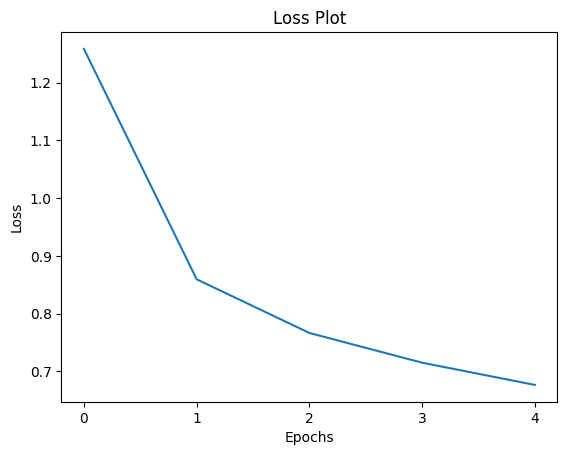

In [47]:
plt.plot(loss_plot)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Plot")
plt.xticks(range(0, len(loss_plot)))
plt.show()

<h3> Добавим еще 10 эпох. Итого 15

In [58]:
EPOCHS = 10

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy() / int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss / num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec\n')

Epoch 1 Batch 0 Loss 0.5648
Epoch 1 Loss 0.646223
Time taken for 1 epoch 120.19 sec

Epoch 2 Batch 0 Loss 0.5664
Epoch 2 Loss 0.618160
Time taken for 1 epoch 119.47 sec

Epoch 3 Batch 0 Loss 0.6473
Epoch 4 Loss 0.572265
Time taken for 1 epoch 119.45 sec

Epoch 5 Batch 0 Loss 0.5277
Epoch 5 Loss 0.552197
Time taken for 1 epoch 119.38 sec

Epoch 6 Batch 0 Loss 0.5214
Epoch 6 Loss 0.530209
Time taken for 1 epoch 119.49 sec

Epoch 7 Batch 0 Loss 0.6229
Epoch 7 Loss 0.509077
Time taken for 1 epoch 119.46 sec

Epoch 8 Batch 0 Loss 0.4751
Epoch 8 Loss 0.485602
Time taken for 1 epoch 119.46 sec

Epoch 9 Batch 0 Loss 0.5123
Epoch 9 Loss 0.463107
Time taken for 1 epoch 119.40 sec

Epoch 10 Batch 0 Loss 0.5077
Epoch 10 Loss 0.439382
Time taken for 1 epoch 119.41 sec



Графики после 15 эпох обучения

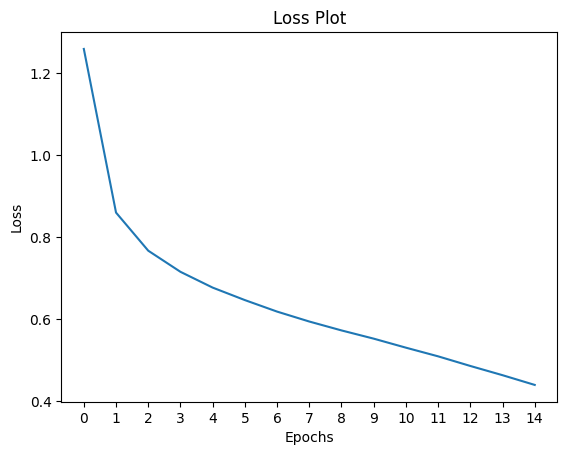

In [59]:
plt.plot(loss_plot)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Plot")
plt.xticks(range(0, len(loss_plot)))
plt.show()

In [61]:
EPOCHS = 5

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy() / int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')

    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss / num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec\n')

Epoch 1 Batch 0 Loss 0.3774
Epoch 1 Loss 0.416109
Time taken for 1 epoch 120.02 sec

Epoch 2 Batch 0 Loss 0.3707
Epoch 2 Loss 0.391488
Time taken for 1 epoch 119.27 sec

Epoch 3 Batch 0 Loss 0.3004
Epoch 3 Loss 0.365186
Time taken for 1 epoch 119.51 sec

Epoch 4 Batch 0 Loss 0.3305
Epoch 4 Loss 0.339577
Time taken for 1 epoch 119.50 sec

Epoch 5 Batch 0 Loss 0.2947
Epoch 5 Loss 0.314695
Time taken for 1 epoch 119.41 sec



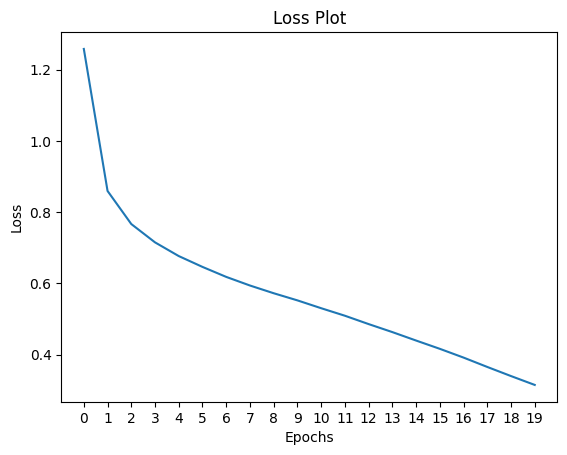

In [62]:
plt.plot(loss_plot)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Plot")
plt.xticks(range(0, len(loss_plot)))
plt.show()

<h2> Подпись

In [48]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word_to_index('')], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(index_to_word(predicted_id).numpy())
        result.append(predicted_word)

        if predicted_word == '':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [49]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(200, 200))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (80, 80))
        grid_size = max(int(np.ceil(len_result/2)), 1)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    # plt.tight_layout()
    plt.show()

In [53]:
!pip install rouge-score bert-score pycocoevalcap -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 16.5 MB/s eta 0:00:00:00:010:01


In [51]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [54]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from bert_score import score as bert_score_fn
from nltk.translate.meteor_score import meteor_score
from nltk.translate.meteor_score import single_meteor_score
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice

chencherry = SmoothingFunction()

rid 1104
BLEU-1: 0.0068
BLEU-2: 0.0048
BLEU-3: 0.0034
BLEU-4: 0.0024
ROUGE-1 score: 0.6875
ROUGE-2 score: 0.3333333333333333
ROUGE-L score: 0.5
METEOR score: 0.289779265613558

CIDEr score: 0.0000
Real report:  cardiac and mediastinal contours are within normal limits the lungs are clear bony structures are intact
Predicted report:  both lungs are clear and epanded heart and mediastinum normal or masses there is atelectasis versus scar unchanged no focal consolidation pleural effusion or pneumothora or cavitary markings no focal air space consolidation no pneumothora or large pleural effusions heart and mediastinum are normal the lungs are clear bilaterally specifically no pneumonia effusions edema pneumothora adenopathy nodules or masses or masses or outside is normal the lungs are clear bilaterally specifically no pneumothora and soft tissues are normal pulmonary vasculature and pulmonary vasculature are normal the mediastinal contour and pulmonary vasculature are within


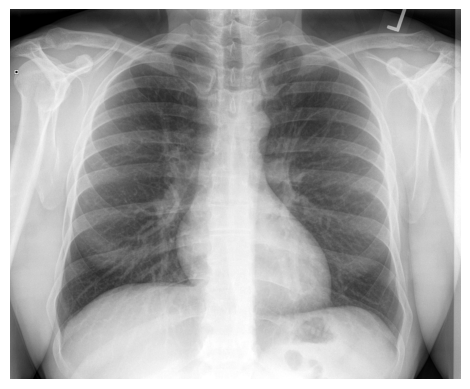

In [66]:
# rid = np.random.randint(0, len(img_name_val))
rid = 1104
print('rid', rid)

image = img_name_val[rid]
img = plt.imread(image)

plt.figure()
plt.imshow(img, cmap = "gray")
plt.axis(False)

real_caption = [tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[rid] if i not in [0]]

result, attention_plot = evaluate(image)
rem = ['startseq', 'start', 'end', 'endseq']

real_caption  = [x for x in real_caption if x not in rem]
result = [x for x in result if x not in rem]

weights = [(1, 0, 0, 0),   # BLEU-1
           (0.5, 0.5, 0, 0), # BLEU-2
           (0.33, 0.33, 0.33, 0), # BLEU-3
           (0.25, 0.25, 0.25, 0.25)] # BLEU-4

bleu_scores = []
for i, weight in enumerate(weights, start=1):
    score = sentence_bleu([result], real_caption, weights=weight, smoothing_function=SmoothingFunction().method5)
    print(f"BLEU-{i}: {score:.4f}")

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge_scores = scorer.score(' '.join(result), ' '.join(real_caption))
print("ROUGE-1 score:", rouge_scores['rouge1'].precision)
print("ROUGE-2 score:", rouge_scores['rouge2'].precision)
print("ROUGE-L score:", rouge_scores['rougeL'].precision)

meteor_score = single_meteor_score(real_caption, result)
print('METEOR score:', meteor_score)

cand_str = " ".join(result)
ref_str  = " ".join(real_caption)
# P, R, F1 = bert_score_fn([cand_str], [ref_str],
#                          lang="en", idf=True, verbose=False)
# print(f"\nBERTScore: {P.mean().item():.4f}  R: {R.mean().item():.4f}  F1: {F1.mean().item():.4f}")

refs  = {0: [ref_str]}
cands = {0: [cand_str]}

cider_scorer = Cider()
cider_score, _     = cider_scorer.compute_score(refs, cands)
print(f"\nCIDEr score: {cider_score:.4f}")

# spice_scorer = Spice()
# spice_score, _     = spice_scorer.compute_score(refs, cands)
# print(f"SPICE score: {spice_score:.4f}")

print('Real report: ', ' '.join([i for i in real_caption]))
print('Predicted report: ', ' '.join(result))

In [ ]:
df[df["findings"].str.startswith("the heart is normal in size atherosclerotic calcifications")]['findings'].iloc[0]

'the heart is normal in size atherosclerotic calcifications of the aorta the mediastinum is stable there is again soft tissue density projected over the right mid chest patients known large breast mass the appearance is grossly stable to decreased from prior study the lateral projection is suboptimal as patient could not raise there is no pleural effusion'

The heart is normal in size. Atherosclerotic calcifications of the aorta. The mediastinum is stable. There is again soft tissue density projected over the right mid chest, XXXX patient's known large breast mass. The appearance is grossly stable to decreased from prior study. The lateral projection is suboptimal as patient could not raise XXXX. There is no pleural effusion.

<h2>Расчет качества модели

In [ ]:
index = len(img_name_val)
cols = ['image', 'real', 'pred', 'bleu', 'rouge_1', 'rouge_l']
dat = pd.DataFrame(columns=cols)

bl = 0
rouge_1 = 0
rouge_l = 0

df_predicted_res = pd.DataFrame()

nums = 50

for j in range(nums):
    image = img_name_val[j]

    real_caption = [tf.compat.as_text(index_to_word(i).numpy())
                            for i in cap_val[j] if i not in [0]]

    result, attention_plot = evaluate(image)

    # removing the start and end tags we initially added
    rem = ['startseq', 'start', 'end', 'endseq']

    real_caption  = [x for x in real_caption if x not in rem]
    result  = [x for x in result if x not in rem]

    print('Real report: ', ' '.join([i for i in real_caption]))
    print('Predicted report: ', ' '.join(result))

    chencherry = SmoothingFunction()
    bl += sentence_bleu([result], real_caption, weights=(1, 0, 0, 0), smoothing_function=chencherry.method5)
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    rouge_scores = scorer.score(' '.join(result), ' '.join(real_caption))
    rouge_1 += rouge_scores['rouge1'].precision
    rouge_l += rouge_scores['rougeL'].precision

    print('Bleu score: ', sentence_bleu([result], real_caption, weights=(1, 0, 0, 0), smoothing_function=chencherry.method5))
    print("ROUGE-1 score:", rouge_scores['rouge1'].precision)
    print("ROUGE-L score:", rouge_scores['rougeL'].precision)

    real_cap =  ' '.join([i for i in real_caption])
    pred_cap = ' '.join(result)
    dat = dat.append({'image': image,
                      'real': real_cap,
                      'pred': pred_cap,
                      'bleu': sentence_bleu([result], real_caption, weights=(1, 0, 0, 0), smoothing_function=chencherry.method5),
                      'rouge_1': rouge_scores['rouge1'].precision,
                      'rouge_l': rouge_scores['rougeL'].precision}, ignore_index=True)
    print('*' * 100)

print("Average bleu score on the test data is ", bl / nums)
print("Average rouge_1 score on the test data is ", rouge_1 / nums)
print("Average rouge_l score on the test data is ", rouge_l / nums)

dat.to_csv('/content/drive/MyDrive/shikha version/data/real_vs_predicted.csv')


Real report:  indications male with chest pain findings low lung volumes with bronchovascular crowding sequela of prior granulomatous disease otherwise lungs clear heart size normal stable severe l deformity impressions low lung volumes with bronchovascular crowding no acute cardiopulmonary finding
Predicted report:  indications male with findings heart size within normal limits surgical clips are low with sulci heart size and pulmonary consolidation pneumothora or pleural effusion there are no focal consolidation no focal consolidation pneumothora or large pleural effusion no abnormal opacity the cardiomediastinal silhouette is within normal limits there is no gross consolidation or large pleural effusion left lower lobe airspace consolidation given differences in the left base atelectasis or focal airspace disease prominent interstitial opacities cardiomediastinal silhouette persistent low lung volumes with bronchovascular crowding patchy bibasilar atelectasis no acute infectioustube

<ipython-input-92-1f0604ee8117>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat = dat.append({'image': image,


Real report:  indications findings the eamination consists of frontal and lateral radiographs of the chest the cardiomediastinal contours lungs pleura osseous structures and visualized upper abdomen are normal impressions unremarkable radiographs of the chest
Predicted report:  indications with asthma and vomiting findings there are no focal areas of acute process stable aorta no focal consolidation pneumothora or pleural effusion the pleural spaces are clear there is no pneumothora or pleural effusion there is a right hilar lymph and eventration question small effusion seen no acute pulmonary disease impressions no acute process mild cardiomegaly calcified granulomas are normal impressions no significant degenerative changes of the thoracolumbar spine fusion cholecystectomy clips mild loss of right rib fractures are present incompletely evaluated impressions no evidence of
Bleu score:  0.11036945593004616
ROUGE-1 score: 0.375
ROUGE-L score: 0.3125
*************************************

<ipython-input-92-1f0604ee8117>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat = dat.append({'image': image,


Real report:  indications female findings cardiomediastinal silhouettes are within normal limits there are right upper lobe lung nodules the largest measuring approimately mm lungs are without focal consolidation pneumothora or pleural effusion bony thora is unremarkable impressions right upper lobe lung nodules recommend
Predicted report:  indications cp sob findings cardiomediastinal silhouette is within normal limits no focal consolidation pneumothora or pleural effusions identified no focal consolidation suspicious pulmonary and lateral view reveals atelectasis in the lower lung base otherwise no focal pulmonary nodules or masses impressions no acute cardiopulmonary abnormalities or focal airspace disease atelectasis no infiltrates heart and lateral chest eamination was obtained the heart silhouette is within normal limits impressions no active disease left ape partially present small calcified aorta stable mediastinal contour are within normal limits for appearance pulmonary conso

<ipython-input-92-1f0604ee8117>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat = dat.append({'image': image,


Real report:  indications female with dyspnea findings cardiac silhouette is normal in size normal mediastinal contour and pulmonary vasculature the lungs are without focal airspace consolidation large pleural effusion or pneumothoraces impressions no acute cardiopulmonary findings
Predicted report:  indications chest pain findings normal heart size left lung consolidation hyperepanded lungs impressions no acute cardiopulmonary abnormality impressions no acute radiographic cardiopulmonary right mid basilar calcified granulomas no acute bony abnormality impressions no acute cardiopulmonary abnormality impressions no acute osseous abnormality identified unremarkable impressions no radiographic evidence of active cardiopulmonary disease impressions no acute cardiopulmonary abnormality impressions no acute osseous abnormalities are normal are normal no focal consolidation pneumothora or large pleural effusion
Bleu score:  0.22775180975865483
ROUGE-1 score: 0.5
ROUGE-L score: 0.323529411764

<ipython-input-92-1f0604ee8117>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat = dat.append({'image': image,


Real report:  indications chest pain findings low lung volumes normal heart size no pneumothora no large effusion no focal infiltrate impressions low lung volumes no acute cardiopulmonary disease
Predicted report:  indications findings pa and lateral views of the lungs with flattening of the cardiac silhouette given overlapping silhouettes are normal the aortic are normal impressions no acute or lung apices the heart size and mediastinal contours the lungs are clear no pleural effusion the heart and clear the mediastinum is stable is stable with ectasia of the right th rib fractures may be helpful for further evaluation with mild to an unchanged cardiomegaly stable mediastinal contours are normal the lungs are clear there is again engorged no active infiltrate or consolidation heart size is within
Bleu score:  0.04879679967025778
ROUGE-1 score: 0.5384615384615384
ROUGE-L score: 0.38461538461538464
*****************************************************************************************

<ipython-input-92-1f0604ee8117>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat = dat.append({'image': image,


Real report:  indications nan findings the lungs are clear heart size is normal no pneumothora impressions clear lungs no acute cardiopulmonary abnormality
Predicted report:  indications findings the heart size and mediastinal contours lungs are clear bilateral breast and left pleural thickening and the left hemidiaphragm of chronic changes and the cheek shortness of breath findings the heart is within normal limits impressions no acute cardiopulmonary disease impressions stable cardiomegaly with stable mild pulmonary vascular structures no acute pulmonary disease there is mild aortic atherosclerotic vascular calcification of the right hemidiaphragm stable cardiomediastinal silhouette has normal size within normal limits for patient history of pneumonia findings the cardiomediastinal silhouette and
Bleu score:  0.03639333542100224
ROUGE-1 score: 0.75
ROUGE-L score: 0.65
****************************************************************************************************


<ipython-input-92-1f0604ee8117>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat = dat.append({'image': image,


Real report:  indications wheezing findings there is opacity left lung base may represent atelectasis or early infiltrate the cardiomediastinal silhouette is within normal limits no pneumothora or pleural effusion impressions opacity left lung base
Predicted report:  indications female chest pain findings low no pleural effusion or pneumothora eaggerated thoracic spondylosis impressions no acute cardiopulmonary findings impressions postoperative left lower lobe calcifications projecting over the left midlung scattered calcified right hilar lymph node or atelectasis impressions no acute osseous abnormality prominent interstitium is normal no focal consolidation no pneumothora or pleural effusion sternotomy noted the lungs are hyperepanded these contour atherosclerotic and soft tissues grossly unremarkable impressions no acute cardiopulmonary abnormalities moderate degenerative changes of the spine impressions no acute
Bleu score:  0.13994716452978495
ROUGE-1 score: 0.5
ROUGE-L score: 0.

<ipython-input-92-1f0604ee8117>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat = dat.append({'image': image,


Real report:  indications female with shortness of breath history of copd findings pa and moderate loss of the chest demonstrate stable moderate cardiomediastinal silhouette with atherosclerotic calcifications of the aortic and mild aortic ectasia emphysematous changes with flattening of the hemidiaphragms blunting of the costophrenic and secondary to scarringemphysematous changes no evidence of focal airspace consolidation large pleural effusion or pneumothora visualized osseous structures appear intact impressions emphysematous changes without evidence of focal airspace disease or pulmonary edema
Predicted report:  indications suspected right midlung with left emphysematous and midback pain findings heart enlargementprominence of focal infiltrate pneumothora or large pleural effusion bony thora is identified there are subpleural change impressions no focal airspace consolidation atelectasis impressions suspected pneumothora impressions no interval change with mild subsegmental atelec

<ipython-input-92-1f0604ee8117>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat = dat.append({'image': image,


Real report:  indications preop knee surgery findings cardiac and mediastinal contours are within normal limits the lungs are clear bony structures are intact impressions no acute preoperative findings
Predicted report:  indications female with findings the heart pulmonary and mediastinal contours no pneumothora or large pleural effusion bony structures the thoracic aorta is calcified mediastinal lymph impressions no lobar consolidation the cardiomediastinal silhouette is normal in size the mediastinum is unremarkable pulmonary vasculature and pulmonary vascularity within normal limits a calcified granulomas no acute bony findings impressions right lower lobe impressions no acute cardiopulmonary disease impressions no acute cardiopulmonary abnormality impressions no acute cardiopulmonary abnormality lungs
Bleu score:  0.1271181257698274
ROUGE-1 score: 0.6153846153846154
ROUGE-L score: 0.46153846153846156
**********************************************************************************

<ipython-input-92-1f0604ee8117>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat = dat.append({'image': image,


Real report:  indications female with history of dyspnea on eertion findings the heart size is normal the mediastinal contour is within normal limits the lungs are free of any focal infiltrates there are no nodules or masses no visible pneumothora no visible pleural fluid the are grossly normal there is no visible free intraperitoneal air under the diaphragm surgical clips are seen the right upper quadrant impressions no acute radiographic cardiopulmonary process
Predicted report:  indications female with shortness of breath days questionable nodule granuloma are normal impressions normal chest or focal airspace disease normal heart size clear lungs no pneumothora or large pleural effusion bony structures appear intact impressions normal chest eam impressions no acute findings impressions no evidence of active disease impressions no active disease impressions no acute cardiopulmonary process impressions negative for adenopathy heart size normal no airspace disease no effusion or pneumo

<ipython-input-92-1f0604ee8117>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat = dat.append({'image': image,


Real report:  indications male pain findings stable cardiomediastinal silhouette with normal heart size mediastinal calcifications suggest a previous granulomatous process apical irregularities also present on the previous eam suggestive of scarring no focal alveolar consolidation no definite pleural effusion seen no typical findings of pulmonary edema no pneumothora impressions no acute findings
Predicted report:  indications with a ladder the left lower lobe and left upper lobe fibrotic changes of the thoracic spine impressions no active pulmonary disease posttraumatic degenerative changes in the spine impressions no acute cardiopulmonary abnormality of renal collecting systems contrast further both lungs are mildly enlarged mediastinum is normal the lungs are clear without evidence of copd impressions no acute cardiopulmonary abnormality lungs are mildly enlarged heart size impressions no acute cardiopulmonary abnormality impressions stable bilateral costophrenic sulci cardiac silho

<ipython-input-92-1f0604ee8117>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat = dat.append({'image': image,


Real report:  indications female with history of aortic stenosis pulmonic stenosis icd codes findings sternotomy appear intact there is no pleural effusion or pneumothora the cardiomediastinal silhouette is within normal limits the pulmonary vasculature is within normal limits there is no focal lung opacity clips overlie the right upper quadrant impressions no acute cardiopulmonary findings
Predicted report:  indications female mvc findings mediastinal contours are within normal limits no focal airspace consolidation pleural effusion or pneumothora heart size and mediastinal contours are normal pulmonary vasculature and pulmonary are unremarkable impressions no acute cardiopulmonary abnormalities impressions no acute cardiopulmonary disease impressions no acute cardiopulmonary finding identified however no bony abnormality the heart size and mediastinal contours no focal airspace consolidation there are no nodules or masses impressions no acute cardiopulmonary abnormalities mm pulmonar

<ipython-input-92-1f0604ee8117>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat = dat.append({'image': image,


Real report:  indications the patient is a male with hiccups and findings the trachea is midline the cardiomediastinal silhouette is normal the lungs are clear without evidence of focal consolidations or pleural effusion there is no pneumothora the visualized bony structures reveal no acute abnormalities impressions no acute cardiopulmonary findings
Predicted report:  indications kidney transplant findings heart size within normal limits no pulmonary edema mild contours are normal no pneumothora heart size within normal limits mild bilateral pleural effusion seen no typical findings of pulmonary edema no evidence of acute process stable left midlung granuloma heart size no evidence of pleural effusion seen no typical mediastinal and pulmonary edema prior granulomatous process no typical findings of pulmonary edema no pleural effusions impressions stable appearance impressions no evidence of acute cardiopulmonary abnormality or adenopathy noted not seen no convincing acute
Bleu score:  

<ipython-input-92-1f0604ee8117>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat = dat.append({'image': image,


Real report:  indications the patient is a male with lung transplant findings right lower lobe infiltrate the trachea is midline negative for pneumothora pleural effusion the heart size is normal there has been interval placement of a left chest with its distal tip in the left sided svc impressions right lower lobe infiltrate suggestive of pneumonia
Predicted report:  indications with rt scapular area and atelectasis or atelectasis no pleural effusion or pneumothora is seen there are only minimal early interstitial thickening and increased lung markings are seen is seen impressions decreased right with scarring lungs are free of infiltrate mass or chronic lung calcified granuloma no pleural effusion or pneumothora impressions no evidence of active disease the mediastinum is stable there is fracture or atelectasis with the heart size is within normal limits the vascularity is within normal limits there is stable atherosclerotic size and vasculature are within normal limits the lungs are

<ipython-input-92-1f0604ee8117>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat = dat.append({'image': image,


Real report:  indications woman with chest pain and shortness of breath findings the lungs are clear bilaterally specifically no evidence of focal consolidation pneumothora or pleural effusion cardiomediastinal silhouette is unremarkable visualized osseous structures of the thora are without acute abnormality impressions no acute cardiopulmonary abnormality
Predicted report:  indications with findings the cardiac contours are normal the lungs are wellinflated and mediastinum normal impressions no active disease or due to overlapping structures are unremarkable impressions no evidence of infiltrate there is evidence of infiltrate there is no effusion or pneumothora identified the bony thora is midline the moderate degenerative changes of the thora are without acute abnormality impressions no active disease or cortical this is stable from the chest were obtained the heart and pulmonary are normal impressions no acute cardiopulmonary abnormality
Bleu score:  0.36739963076722904
ROUGE-1 sc

<ipython-input-92-1f0604ee8117>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat = dat.append({'image': image,


Real report:  indications male rule out pneumonia findings calcified left hilar lymph from prior granulomatous disease the cardiomediastinal silhouette is within normal limits for size pulmonary vasculature is within normal limits no focal consolidations effusions or pneumothoraces no acute bony abnormality impressions no acute cardiopulmonary abnormality
Predicted report:  indications male with positive ppd with chest pain findings the heart size is normal the lungs are clear without focal consolidation is mildly enlarged mediastinal contours are within normal limits no focal consolidation there is no mediastinal contours are within normal limits impressions normal chest impressions no acute changes the are intact impressions no active disease impressions no acute cardiopulmonary abnormality impressions no acute cardiopulmonary abnormality impressions no acute cardiopulmonary disease impressions lobulated
Bleu score:  0.41269051409047375
ROUGE-1 score: 0.5681818181818182
ROUGE-L score

<ipython-input-92-1f0604ee8117>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat = dat.append({'image': image,


Real report:  indications woman with pain findings the lungs are clear bilaterally specifically no evidence of focal consolidation pneumothora or pleural effusion cardiomediastinal silhouette is unremarkable heart size upper limit of normal visualized osseous structures of the thora are without acute abnormality impressions no acute cardiopulmonary abnormality
Predicted report:  indications male status post assault or free air collections and worsening of chest eam have increased interstitial markings the heart size and mediastinal contours the lungs are clear the lungs are clear there are no focal consolidation pneumothora or pleural effusion which could be helpful or lymphoma findings there is an acute cardiopulmonary abnormalities lungs have in the interval both lungs are clear the cardiomediastinal silhouette is within normal limits impressions no acute disease history of endstage renal cell tumor findings the lungs or focal
Bleu score:  0.3542902045633489
ROUGE-1 score: 0.66666666

<ipython-input-92-1f0604ee8117>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat = dat.append({'image': image,


Real report:  indications dyspnea findings heart size and pulmonary vascularity within normal limits no focal infiltrate pneumothora or pleural effusion identified impressions no acute cardiopulmonary disease
Predicted report:  indications male with chest pain findings the heart and pulmonary are normal mediastinal contours are within normal limits there is no evidence of pneumonia lungs have in the interval both lungs are free of focal airspace disease effusion or pneumothora impressions no acute cardiopulmonary abnormalities impressions no acute cardiopulmonary abnormality impressions right apical pneumothora or focal airspace disease the remainder of the image and posterior third and back pain findings the cardiac silhouette is enlarged the pulmonary are otherwise
Bleu score:  0.09450448857500889
ROUGE-1 score: 0.75
ROUGE-L score: 0.6666666666666666
****************************************************************************************************


<ipython-input-92-1f0604ee8117>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat = dat.append({'image': image,


Real report:  indications chest pain findings heart size and mediastinal contours appear within normal limits pulmonary vascularity is within normal limits no focal consolidation suspicious pulmonary opacity pneumothora or definite pleural effusion visualized osseous structures appear intact impressions no acute cardiopulmonary abnormality
Predicted report:  indications male with chest pain findings the heart size and mediastinal silhouette no focal consolidation pneumothora no pleural effusion or pneumothora is seen no acute displaced rib fractures impressions no active pulmonary disease lungs have in unremarkable chest lungs have in unremarkable chest eam impressions no acute cardiopulmonary abnormality or pneumothora visualized osseous structures appear intact left suprahilar the cardiomediastinal silhouette and mediastinal contours no pneumothora pleural effusion or pneumothora calcified granuloma no focal airspace consolidation no pleural effusion or pneumothora normal heart size 

<ipython-input-92-1f0604ee8117>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat = dat.append({'image': image,


Real report:  indications female with findings the heart is normal size the mediastinum is unremarkable there is no pleural effusion pneumothora or focal airspace disease the are unremarkable impressions no acute cardiopulmonary abnormality
Predicted report:  indications female with onset pleuritic chest pain findings lungs are clear bilaterally cardiac and mediastinal silhouettes are unremarkable there are stable with no focal consolidation no pneumothora or pleural effusion normal cardiomediastinal silhouettes negative for pneumothora impressions negative for acute cardiopulmonary disease or chronic right lower lobe are present within the lateral image and intact calcified granuloma the aortic ectasia and tortuosity and unchanged eventration of the abdomen are normal impressions clear lungs impressions negative chest were obtained the cardiomediastinal silhouette is normal in size and contour
Bleu score:  0.1541109407806291
ROUGE-1 score: 0.7741935483870968
ROUGE-L score: 0.451612903

<ipython-input-92-1f0604ee8117>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat = dat.append({'image': image,


Real report:  indications findings the cardiac silhouette and mediastinal contours are within normal limits there is no focal opacity there is no pneumothora there is no large pleural effusion impressions no acute cardiopulmonary disease
Predicted report:  indications dyspnea findings no focal areas of consolidation heart size clear lungs clear no pneumothora or pleural effusion identified multilevel degenerative changes are unremarkable impressions no acute lung bases the lungs are clear there is no pneumothora or pleural effusion mildly epanded with clear no pneumothora or pleural effusion are available for pneumonia impressions no acute cardiopulmonary findings impressions no acute cardiopulmonary abnormality or infiltrate with scarring or lymphadenopathy impressions no acute cardiopulmonary abnormalities impressions no acute
Bleu score:  0.18955959722553786
ROUGE-1 score: 0.53125
ROUGE-L score: 0.46875
********************************************************************************

<ipython-input-92-1f0604ee8117>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat = dat.append({'image': image,


Real report:  indications metastatic breast cancer findings the pulmonary nodules and masses masses on previous eam are smaller and not definitely seen the lungs are otherwise clear heart size normal no pneumothora there is a right chest with tip projecting over the lower svc impressions interval decrease in size of numerous pulmonary nodules and masses no nodules or masses are definitely seen on radiograph
Predicted report:  indications chest pain and dyspnea findings cardiac and mediastinal contours are within normal limits the lungs are clear bilaterally cardiac and mediastinal contours are within normal limits mild scoliosis and calcified granuloma noted impressions no acute cardiopulmonary abnormality or adenopathy is clear impressions no acute cardiopulmonary abnormality or pneumothora are unremarkable impressions no acute cardiopulmonary abnormality or adenopathy or masses no acute bony abnormality impressions no acute cardiopulmonary abnormality heart size normal no focal airsp

<ipython-input-92-1f0604ee8117>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat = dat.append({'image': image,


Real report:  indications bleed findings in the interval a cm uncalcified mass has developed in the posterior segment of the right upper lobe in addition on the pa view an mm opacity is adjacent to the left of the heart this opacity cannot be well identified on the lateral view it may be artifactual but another mass on the left cannot be ecluded mediastinum is normal with no evidence for adenopathy heart size normal note of an unchanged hiatal hernia impressions right upper lobe mass suspicious for neoplasm ct of chest abdomen and head would be
Predicted report:  indications shortness of breath findings the cardiomediastinal silhouette is normal in size tortuosity of the to represent dilated small calcified granuloma no focal areas of consolidation interface in size tortuosity of the lungs no mediastinal contours are normal in size the stomach contours lungs are clear without focal airspace consolidation minimal atelectasis left chest show an unchanged leftsided cardiomediastinal silho

<ipython-input-92-1f0604ee8117>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat = dat.append({'image': image,


Real report:  indications chest pain findings mediastinal contours are normal lungs are clear there is no pneumothora or large pleural effusion impressions no acute cardiopulmonary abnormality
Predicted report:  indications unavailable findings lungs are clear bilateral glenohumeral degenerative changes are grossly unremarkable impressions negative for acute cardiopulmonary abnormality impressions right lower lobe calcified granuloma or infiltrate impressions no acute cardiopulmonary abnormalities impressions chest radiograph stable chest findings and epanded heart size and cardiomediastinal silhouette and pulmonary vascularity are within normal limits no focal consolidation effusion or pneumothora impressions chest radiograph no acute cardiopulmonary abnormality impressions unremarkable eamination and mediastinal contours are unremarkable no consolidation stable leftsided
Bleu score:  0.10736215098974013
ROUGE-1 score: 0.7916666666666666
ROUGE-L score: 0.5
****************************

<ipython-input-92-1f0604ee8117>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat = dat.append({'image': image,


Real report:  indications female pain findings heart size within normal limits no focal alveolar consolidation no definite pleural effusion seen no typical findings of pulmonary edema no pneumothora impressions no acute cardiopulmonary findings
Predicted report:  indications chest pain findings the lungs are clear bilaterally cardiac and mediastinal contours are within normal limits the lungs are normally inflated with no fractures impressions negative for acute cardiopulmonary findings impressions no acute cardiopulmonary abnormality impressions no acute cardiopulmonary findings lungs are clear bilaterally impressions no acute cardiopulmonary abnormality lungs are within the spine normal impressions no acute cardiopulmonary abnormality or mediastinal lymphadenopathy findings cardiac and soft tissues are unremarkable
Bleu score:  0.20781665763729618
ROUGE-1 score: 0.5161290322580645
ROUGE-L score: 0.5161290322580645
**********************************************************************

<ipython-input-92-1f0604ee8117>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat = dat.append({'image': image,


Real report:  indications male with chest pain findings heart size normal no focal airspace disease no pneumothora or effusions impressions no acute cardiopulmonary findings
Predicted report:  indications male with findings frontal and lateral views were obtained the osseous structures are intact impressions no evidence of acute osseous abnormality mild degenerative disc disease impressions round opacity no acute displaced rib fractures impressions no evidence of acute cardiopulmonary abnormality impressions chest nodule findings lungs have a few scattered calcified granuloma within the distal left suprahilar calcified granuloma noted no convincing acute osseous abnormality impressions negative chest tip at the anterior loss findings no acute displaced rib fractures seen no convincing acute
Bleu score:  0.05040787839489473
ROUGE-1 score: 0.5909090909090909
ROUGE-L score: 0.5454545454545454
*************************************************************************************************

<ipython-input-92-1f0604ee8117>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat = dat.append({'image': image,


Real report:  indications male with dyspnea findings lungs are hyperinflated but clear no focal infiltrate or effusion heart and mediastinal contours within normal limits calcified mediastinal identified impressions hyperinflated but clear lungs
Predicted report:  indications dyspnea findings the heart is mildly enlarged stable valve noted with no focal areas of a mm bilateral pulmonary edema or chronic lung changes impressions no acute findings there are opacities are intact impressions continued elevation of the distal left costophrenic blunting no focal consolidation atelectasis no pneumothora no large pleural effusion or focal consolidation impressions no acute intrathoracic abnormality impressions no evidence for bilateral pleural effusion or pleural effusion right chest if an ap diameter consolidation impressions postoperative changes
Bleu score:  0.10975010180639383
ROUGE-1 score: 0.4
ROUGE-L score: 0.3333333333333333
*************************************************************

<ipython-input-92-1f0604ee8117>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat = dat.append({'image': image,


Real report:  indications female short of breath chest pain findings heart size within normal limits stable mediastinal and hilar contours no focal alveolar consolidation no definite pleural effusion seen bronchovascular crowding without typical findings of pulmonary edema impressions no acute findings
Predicted report:  indications female on liters findings marked cardiomegaly unfolding of the spine stable cholecystectomy impressions findings there are no of pleural effusion impressions stable appearance is in the right lung opacity in left lung there are degenerative changes of the spine and soft tissue are seen lungs have in the interval no focal consolidation pleural effusion or pneumothora impressions left upper lobe interstitial pulmonary edema small right atrial enlargement of the right basilar atelectasis and right central venous catheter distal thoracic spine right hilar lymph suggesting
Bleu score:  0.21311715135031375
ROUGE-1 score: 0.48717948717948717
ROUGE-L score: 0.33333

<ipython-input-92-1f0604ee8117>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat = dat.append({'image': image,


Real report:  indications female with persistent for months findings the lungs are clear there is no focal airspace consolidation no pleural effusion or pneumothora heart size and mediastinal contour are normal there are minimal degenerative changes of the spine impressions no evidence of active disease
Predicted report:  indications findings the lungs are clear the lungs are clear there is no pneumothora there is no evidence of active disease impressions low lung volumes are stable right suprahilar the trachea is midline the cardiac silhouette there is no evidence of pneumonia the cardiac silhouette are normal there is no evidence of pneumonia impressions right upper lobe there is mild degenerative changes of the spine impressions of two bullae are without evidence of consolidation a right base otherwise no pneumothora or pleural effusions no focal consolidation pneumothora
Bleu score:  0.34117968983550157
ROUGE-1 score: 0.7209302325581395
ROUGE-L score: 0.4883720930232558
***********

<ipython-input-92-1f0604ee8117>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat = dat.append({'image': image,


Real report:  indications low back pn findings chest there is no change in the strandy scarring in the right ape no infiltrates or masses in the lungs heart and mediastinum remain normal lumbosacral spine disc spaces are old narrow and large osteophytes present on the vertebral bodies worst at ll elements from l through s are sclerotic sacrum and sacroiliac joints are normal calcific aortic disease is present impressions chest no change right upper lobe scar no acute disease lumbosacral spine multiple levels of advanced degenerative disc disease and arthritis
Predicted report:  indications esophageal carcinoma findings lungs appear clear heart size aortic calcifications are noted the lungs are normally inflated with flattening of the right costophrenic this appears unchanged in the right proimal humerus incompletely evaluated a male with notified of the left costophrenic sulcus could be posttraumatic or masses no pneumonia or consolidation stable appearing contour interval innumerable 

<ipython-input-92-1f0604ee8117>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat = dat.append({'image': image,


Real report:  indications findings in the interval consolidation and atelectasis have developed in the right lower lobe costophrenic blunted on the right left lung clear heart size normal impressions left lower lobe airspace disease consistent with pneumonia associated right pleural effusion
Predicted report:  indications female female with shortness of breath findings normal heart normal pleural effusion or focal airspace disease or bone destruction note of infection impressions chest no acute cardiopulmonary abnormality mm nodule normal heart size stable there are bilateral pulmonary consolidation no pleural effusion is noted high tuberculosis findings normal heart size upper mediastinum are unremarkable there is stable cardiomediastinal silhouette normal impressions scattered calcified testes bilaterally and mediastinal contour are normal there are stable mild heart size is upper lung volumes are normal
Bleu score:  0.19667204095989668
ROUGE-1 score: 0.358974358974359
ROUGE-L score:

<ipython-input-92-1f0604ee8117>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat = dat.append({'image': image,


Real report:  indications shortness of breath findings the trachea is midline the cardiomediastinal silhouette is normal in size and unchanged from prior eaminations with sternotomy and surgical clips overlying there is blunting of the right costophrenic which appears unchanged from prior eamination and may be secondary to scarring or pleural thickening of the right lung base there is no evidence of acute infiltrate there is no pneumothora visualized bony structures reveal no acute abnormalities impressions hyperepanded lung no acute cardiopulmonary abnormalities
Predicted report:  indications weakness shoulder pain findings lungs are hyperepanded with no pneumothora pleural effusion or pneumothora impressions interval a vascular calcifications within the hilar fullness of the left hemidiaphragm no visualized pneumothora or large pleural effusion degenerative changes of the spine impressions normal chest or small calcified granulomata are noted stable appearance impressions no interval

<ipython-input-92-1f0604ee8117>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat = dat.append({'image': image,


Real report:  indications male for rule out pneumothora findings small mm rightsided pneumothora only visible on the left lateral decubitus film left lung is clear normal cardiac contour no evidence of pleural effusion impressions small mm rightsided pneumothora
Predicted report:  indications ppd findings the heart size is within normal limits for acute osseous abnormality no pneumothora no pneumothora or large pleural effusion mildly enlarged heart size minimal left a stable mediastinal contours no focal consolidation pneumothora or large calcified lymph lung calcified granuloma no pneumothora no visible pneumothora calcified left base bony structures appear stable mild degenerative changes identified no pleural effusions edema fracture noted with calcified mediastinal adenopathy is identified findings the lungs are free of focal consolidation pneumothora no large pleural effusion or focal consolidation or pleural effusion no acute abnormalities
Bleu score:  0.13501325099038475
ROUGE-

<ipython-input-92-1f0604ee8117>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat = dat.append({'image': image,


Real report:  indications and symptoms findings the cardiomediastinal silhouette is normal size and configuration pulmonary vasculature within normal limits the lungs are wellaerated there is no pneumothora pleural effusion or focal consolidation impressions no acute cardiopulmonary disease
Predicted report:  indications findings the cardiomediastinal silhouette is normal in size the bilaterally and mediastinal contours are within normal limits are unremarkable there are calcified mediastinal no pleural effusion or pneumothora identified degenerative changes are intact a wedgeshaped fracture low lung bilaterally the heart pulmonary and mediastinal contours are unremarkable mediastinal contour and pulmonary vasculature are within normal limits no focal consolidation no pneumothora there is no pleural effusion or pneumothora numerous calcified mediastinal contour within normal limits no focal areas of consolidation impressions no acute disease impressions no acute cardiopulmonary abnorma

<ipython-input-92-1f0604ee8117>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat = dat.append({'image': image,


Real report:  indications nan findings there is an ovoid opacity cm in the retrocardiac area on ap view not wellseen on the lateral view a dedicated scan is recommended no pneumothora or pleural effusion present the heart is normal in size no hilar lymphadenopathy no destructive bony lesions impressions no acute cardiopulmonary abnormalities an ovoid opacity in the left retrocardiac area could be projectional or solid mass further study is recommended
Predicted report:  indications male findings a small calcified mediastinal and mediastinal contours are within normal limits stable mediastinal and mediastinal contour within normal limits calcified right hemidiaphragm no typical findings of normal mediastinal contours are normal impressions no acute disease impressions no evidence of breath dizziness findings the cardiomediastinal silhouette is near the spine impressions no acute cardiopulmonary findings impressions no acute cardiopulmonary disease no evidence of acute pulmonary disease 

<ipython-input-92-1f0604ee8117>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat = dat.append({'image': image,


Real report:  indications leftsided chest pain under left breast three days findings minimal opacities at the posterior sulci a few septal lines of the left lateral sulcus otherwise the lungs are clear with granulomas and sulci heart size upper normal thin lv contourunfolded calcified aorta tspine small osteophytes impressions no pneumothora similar appearance
Predicted report:  indications copd headache findings cardiac silhouette stable right with mild bibasilar patchy edema there is no pneumothora or effusion mild degenerative changes of the spine impressions minimal right basilar atelectasis no pneumothora left midline sternotomy and deep opacity may be related to lymph node there are degenerative changes are intact impressions negative chest are blunted aortic changes with redemonstration of large pleural effusion impressions emphysema without pulmonary vascular congestion no pneumothora right basal atelectasis since the lateral view as compared to prior eam question small pleural

<ipython-input-92-1f0604ee8117>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat = dat.append({'image': image,


Real report:  indications preprocedure evaluation prior to bone marrow transplant findings the lungs appear clear there are no suspicious pulmonary nodules or infiltrates the heart and pulmonary appear normal the pleural spaces are clear mediastinal contours are normal there is a leftsided tunneled catheter the distal tip at the mid superior level impressions no acute cardiopulmonary disease
Predicted report:  indications nan findings the lungs are clear there is no focal air space opacities pleural effusion or pneumothora is seen vp shunt tubing is grossly normal size and pulmonary are normal the lungs are clear thoracic spondylosis impressions no acute pulmonary disease impressions no acute pulmonary disease impressions no acute cardiopulmonary disease or focal airspace disease as to the left knee there is a vascular congestion normal heart size and pulmonary vascularity are within normal limits in size and contour aortic appear normal
Bleu score:  0.47813510629732403
ROUGE-1 score: 

<ipython-input-92-1f0604ee8117>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat = dat.append({'image': image,


Real report:  indications placement findings heart size normal lungs are clear are normal no pneumonia effusions edema pneumothora adenopathy nodules or masses impressions normal chest no evidence of tuberculosis
Predicted report:  indications dyspnea findings normal cardiac silhouette normal the lungs are clear bilaterally specifically no evidence of focal consolidation pneumothora or pleural disease consistent with clear lungs negative for pneumothora impressions low lung volumes on bilateral interstitial disease impressions negative for acute abnormality large hiatal hernia clear or adenopathy or possibly lymphadenopathy consistent with chronic interstitial and reflects scar of the upper lungs heart size normal there is bibasilar airspace disease lungs no pneumothora or large pleural effusions impressions clear lungs no pneumothora or large pleural
Bleu score:  0.10262513193207552
ROUGE-1 score: 0.7037037037037037
ROUGE-L score: 0.4444444444444444
***********************************

<ipython-input-92-1f0604ee8117>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat = dat.append({'image': image,


Real report:  indications and hypoia findings heart size and mediastinal contours appear within normal limits pulmonary vascularity is within normal limits no focal consolidation suspicious pulmonary opacity pneumothora or definite pleural effusion visualized osseous structures appear intact impressions no acute cardiopulmonary abnormality
Predicted report:  indications male findings the heart is normal in size with no acute cardiopulmonary abnormality impressions no acute cardiopulmonary abnormality findings the lungs are clear bilaterally specifically no evidence of focal airspace disease pneumothora or pleural effusion negative for acute bony abnormality impressions no acute cardiopulmonary abnormality impressions no acute cardiopulmonary abnormality impressions no acute cardiopulmonary abnormalities or magnified appearance of the chest the chest complaints findings lungs
Bleu score:  0.34009037838017064
ROUGE-1 score: 0.45
ROUGE-L score: 0.4
****************************************

<ipython-input-92-1f0604ee8117>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat = dat.append({'image': image,


Real report:  indications the patient is a with back pain findings the trachea is midline cardiomediastinal silhouette is normal the lungs are clear without evidence of focal consolidation or pleural effusion there is no pneumothora the visualized bony structures reveal no acute abnormalities impressions no acute cardiopulmonary abnormalities
Predicted report:  indications hemoptysis findings the cardiomediastinal contours are within normal limits no pleural effusion or focal airspace consolidation the cardiac silhouette mediastinal calcifications impressions normal chest impressions chest evidence of acute cardiopulmonary disease impressions no acute disease impressions no acute cardiopulmonary findings small calcified left shoulder impressions normal chest impressions no acute cardiopulmonary findings impressions unremarkable left chest impressions normal chest impressions unremarkable chest the lungs are clear
Bleu score:  0.4876086758477133
ROUGE-1 score: 0.5434782608695652
ROUGE-L

<ipython-input-92-1f0604ee8117>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat = dat.append({'image': image,


Real report:  indications dyspnea history of prostate cancer shortness of breath nausea patient on chemotherapy findings there is a rightsided chest identified whose distal tip projects over the svc heart size is normal low lung volumes with elevated right hemidiaphragm the lungs are grossly clear no focal infiltrate no pleural effusion or pneumothora normal pulmonary vascularity normal mediastinal and hilar contours degenerative changes of the spine impressions low lung volumes no acute abnormality
Predicted report:  indications male presents for evaluation with history impressions low lung consolidation no pleural effusion or airspace disease identified no pulmonary edema impressions mild cardiomegaly or adenopathy there is elevated right lateral view lungs with cardiomegaly no focal infiltrate there is right right mid lung no significant pleural effusion findings there are low lung volumes no pneumothora heart size is enlarged stable impressions low lung volumes no significant pleur

<ipython-input-92-1f0604ee8117>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat = dat.append({'image': image,


Real report:  indications pt co cp findings the heart and lungs have in the interval both lungs are clear and epanded heart and mediastinum normal impressions no active disease
Predicted report:  indications rule out sarcoidosis findings the heart silhouette is unremarkable there is distal thoracic spine no nodules or masses no large pleural effusion or pneumothora impressions unremarkable eam thora are without acute abnormality low lung volumes with blunted right hemidiaphragm no possible right upper lobe airspace disease otherwise clear on chest with no focal airspace consolidation no pneumothora impressions unremarkable chest with no pneumothora or pleural effusions mild degenerative changes of the spine specifically no evidence of acute radiographic cardiopulmonary process there are no radiographic evidence of
Bleu score:  0.0656588782673975
ROUGE-1 score: 0.4074074074074074
ROUGE-L score: 0.2962962962962963
**************************************************************************

<ipython-input-92-1f0604ee8117>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat = dat.append({'image': image,


Real report:  indications dyspnea findings cardiomediastinal silhouette is within normal limits of size and appearance the pulmonary vascularity is unremarkable lungs are epanded and clear of airspace disease negative for pneumothora or pleural effusion limited bone evaluation reveals no acute abnormality there is incompletely evaluated lumbar levoscoliosis impressions no acute cardiopulmonary abnormality
Predicted report:  indications chest pain findings normal heart size within normal limits no acute bony abnormality impressions no radiographic evidence of acute cardiopulmonary findings impressions heart silhouette is within normal limits no pleural effusions or pneumothoraces the thora intact impressions no acute cardiopulmonary abnormality impressions no acute cardiopulmonary abnormality impressions no active cardiopulmonary disease impressions no acute findings impressions no active cardiopulmonary disease or adenopathy is due to large
Bleu score:  0.489620510460919
ROUGE-1 score:

<ipython-input-92-1f0604ee8117>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat = dat.append({'image': image,


Real report:  indications female with history of leukocytosis findings stable cardiomegaly and mediastinal contour increased interstitial lung markings are seen possibly due to volume overload there is improved aeration of the lung bases with small residual left basilar effusion no focal consolidation or pneumothora stable tunneled dialysis catheter visualized osseous structures appear intact impressions stable cardiomegaly improved aeration of lung bases with persistent left basilar effusion prominent interstitium possibly due to mild volume overload
Predicted report:  indications nan findings cardiomegaly and may be secondary to scarring impressions cardiomegaly with left basilar opacity with mild pacemakerdefibrillator terminating with correlate for further evaluation if warranted there minimal bibasilar patchy bibasilar opacity probable right lateral rib fracture impressions stable appearance of the right either atelectasis there is eventration of the left th rib may represent mild

<ipython-input-92-1f0604ee8117>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat = dat.append({'image': image,


Real report:  indications chest pain findings the heart size is normal and cardiomediastinal silhouette is normal in contour lungs are clear bilaterally there is no pleural effusion or pneumothora no bony or soft tissue abnormalities impressions no acute cardiopulmonary abnormality
Predicted report:  indications test ca for one findings both lungs are clear small bilateral pleural effusion impressions normal chest impressions hyperepanded lungs consistent with epanded heart size normal no pleural effusion or focal area of pneumothora adenopathy nodules or masses identified calcified granuloma in the left costophrenic sulcus could obscure a mm calcified granuloma right middle lobe the cardiomediastinal silhouette is normal impressions mild heart size within normal limits lungs are clear multilevel cervical spine curvature the lumbar spine impressions normal chest impressions hyperepanded lungs
Bleu score:  0.24490619197934982
ROUGE-1 score: 0.6052631578947368
ROUGE-L score: 0.3421052631

<ipython-input-92-1f0604ee8117>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat = dat.append({'image': image,


Real report:  indications asthma findings lungs are clear no pleural effusions or pneumothoraces heart and mediastinum are stable with normal sized heart degenerative changes in the spine impressions clear lungs
Predicted report:  indications ordering a followup chest pain preop bilateral rib pain findings heart size within normal limits no pneumothora pleural effusion or pneumothora there is mild pectus ecavatum deformity of rightsided chest congestion presents followup chest pain symptoms for weeks to chills and difficulty findings heart size noted impressions no acute cardiopulmonary abnormality heart size and pulmonary vascularity appear within normal limits there is an interim cervical spine there has been previous eam there is blunting of the skeletal structures which could represent a pneumonia there is again scar or
Bleu score:  0.07007813053726517
ROUGE-1 score: 0.5
ROUGE-L score: 0.35714285714285715
*****************************************************************************

<ipython-input-92-1f0604ee8117>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat = dat.append({'image': image,


Real report:  indications shortness of breath findings normal heart size normal mediastinal silhouette no pneumothora pleural effusion or suspicious focal air space opacity impressions normal eam
Predicted report:  indications with shortness of breath findings the lungs are clear without focal air collections or focal airspace disease nodular opacity in the superior lungs are clear no pleural effusion is unremarkable no pneumothora or pleural effusion stable normal impressions no active pulmonary disease impressions no acute cardiopulmonary abnormality impressions no acute cardiopulmonary abnormality or focal airspace consolidation pleural effusion or pneumothora impressions no acute cardiopulmonary abnormality or focal consolidation no pneumothora there is no pneumothora or pleural effusion impressions
Bleu score:  0.08607966982607398
ROUGE-1 score: 0.625
ROUGE-L score: 0.5
****************************************************************************************************


<ipython-input-92-1f0604ee8117>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat = dat.append({'image': image,


Real report:  indications vomiting diarrhea chills findings heart size and vascularity normal mediastinal contour normal lungs are clear no pleural effusions or pneumothoraces impressions normal chest
Predicted report:  indications loss of the t and lower lobe pneumonia recommend follow up to shoulder pain gunshot wound years ago findings heart size and mediastinal contour within normal limits no focal airspace consolidation pneumothora or pleural effusion no convincing acute bony findings impressions no acute cardiopulmonary abnormalities impressions no evidence of active disease impressions no acute cardiopulmonary abnormalities are clear there is no focal consolidation pleural effusion or pneumothora osseous structures and soft tissues are intact impressions no acute pulmonary abnormality
Bleu score:  0.07706226431736536
ROUGE-1 score: 0.625
ROUGE-L score: 0.625
****************************************************************************************************


<ipython-input-92-1f0604ee8117>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat = dat.append({'image': image,


Real report:  indications male with chest pain findings heart size normal no focal airspace disease no pneumothora or effusions impressions no acute cardiopulmonary findings
Predicted report:  indications male with findings the lungs are clear impressions no acute cardiopulmonary abnormality impressions no acute cardiopulmonary finding impressions no evidence of acute cardiopulmonary abnormalities or visualized osseous structures are intact no focal consolidation pneumothora or large pleural effusion impressions no active disease or soft tissues are intact impressions negative chest were obtained the cardiomediastinal silhouette is normal in size with clear impressions no acute cardiopulmonary abnormality impressions no acute cardiopulmonary abnormality
Bleu score:  0.0988679427158343
ROUGE-1 score: 0.8636363636363636
ROUGE-L score: 0.5909090909090909
****************************************************************************************************


<ipython-input-92-1f0604ee8117>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat = dat.append({'image': image,


Real report:  indications hemorrhagic infarct increased bnp findings heart size is within normal limits emphysematous changes focal pleural thickening in the left ape is scarring atherosclerotic calcifications of the aortic there is no focal infiltrate no pneumothora or pleural effusion impressions emphysema without acute cardiopulmonary findings
Predicted report:  indications tripped inflated and mediastinum normal no pleural effusion no focal areas of consolidation no pleural effusions no pleural effusion no pneumothora no pneumothora no pleural effusions no acute pulmonary disease there is approimately mm left no pneumothora no pleural effusions no suspicious pulmonary no pleural effusion no evidence of apical opacity that fractures impressions no acute disease impressions no acute cardiopulmonary abnormality identified or small calcified granuloma no focal areas of pulmonary vascular congestion no focal leftsided rotated the cardiomediastinal silhouette and pulmonary vascular opaci

<ipython-input-92-1f0604ee8117>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dat = dat.append({'image': image,


In [ ]:
prediction = pd.read_csv('/content/drive/MyDrive/shikha version/data/real_vs_predicted.csv')
prediction

,Unnamed: 0,image,real,pred,bleu,rouge_1,rouge_l
0,0,/content/images/images_normalized/1119_IM-0080...,indications male with chest pain findings low ...,indications male with findings heart size with...,0.162005,0.526316,0.447368
1,1,/content/images/images_normalized/2376_IM-0936...,indications findings the eamination consists o...,indications with asthma and vomiting findings ...,0.110369,0.375000,0.312500
2,2,/content/images/images_normalized/1581_IM-0378...,indications female findings cardiomediastinal ...,indications cp sob findings cardiomediastinal ...,0.204601,0.463415,0.365854
3,3,/content/images/images_normalized/865_IM-2385-...,indications female with dyspnea findings cardi...,indications chest pain findings normal heart s...,0.227752,0.500000,0.323529
4,4,/content/images/images_normalized/3717_IM-1856...,indications chest pain findings low lung volum...,indications findings pa and lateral views of t...,0.048797,0.538462,0.384615
5,5,/content/images/images_normalized/3646_IM-1808...,indications nan findings the lungs are clear h...,indications findings the heart size and medias...,0.036393,0.750000,0.650000
6,6,/content/images/images_normalized/3813_IM-1922...,indications wheezing findings there is opacity...,indications female chest pain findings low no ...,0.139947,0.500000,0.375000
7,7,/content/images/images_normalized/1173_IM-0118...,indications female with shortness of breath hi...,indications suspected right midlung with left ...,0.536325,0.368421,0.171053
8,8,/content/images/images_normalized/3223_IM-1523...,indications preop knee surgery findings cardia...,indications female with findings the heart pul...,0.127118,0.615385,0.461538
9,9,/content/images/images_normalized/2229_IM-0831...,indications female with history of dyspnea on ...,indications female with shortness of breath da...,0.567890,0.385714,0.242857
